In [5]:
import nbsetup
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from references.sparc import galaxy_list
from models.load import load_sparc, DIR

In [2]:
simulations = load_sparc(galaxy_list(), DIR+'rar_')

In [42]:
def velocity(R, F):
    return np.sign(F)*(np.abs(R*F)**0.5)

BOUNDS = [[1,0],[np.inf,1]]

def curve_fit(self):
    
    # combined masses dataframe
    cdf = self.dataframe(mass_ratios=self.profile.mass_ratios(), combined=True)
    
    def f(r, gamma, alpha):
        inulled = np.interp(r, cdf['rd'], cdf['x_abs']-cdf['x_vec'])
        iforce = np.interp(r, cdf['rd'], cdf['x_vec'])
        nforce = gamma*iforce/(1+((inulled))**alpha)
        return velocity(r, nforce)
    
    # rotmass reference dataframe
    rdf = self.profile.rotmass_df
    leng = int(len(rdf['R'])*0.9)
    bounds = BOUNDS
    popt, pcov = sp.optimize.curve_fit(f, rdf['R'][:leng], rdf['Vobs'][:leng], bounds=bounds)
    return popt, pcov, f

In [44]:
def sparc_dataframe(self):
    # use rotmass as the basis of the dataframe
    # (might be better to use mass model though)
    df = self.profile.rotmass_df.copy()
    
    # sparc table1 augments
    for k in ('D', 'e_D', 'Inc', 'e_Inc', 'Vflat', 'e_Vflat', 'Q', 'MHI', 'L[3.6]'):
        df[k] = self.profile.sparc_dict[k]
    
    # additional calculations
    df['u_Inc'] = self.profile.inc_used
    df['rel_R'] = df['R']/df['R'].max()
    df['mhi_R'] = df['R']/df['MHI']
    
    # calculated newtonian velocities
    # ignore mass ratios for now
    # as rotmass is benchmarked to 1 M/L
    # will adjust for them later
    sim_df = self.dataframe(mass_ratios=False)
    
    for component, cdf in sim_df.groupby('component'):
        R = df['R']
        F = np.interp(R, cdf['rd'], cdf['x_vec'])
        df['W%s' % component] = velocity(R, F)
        
    # calculate gravity components Vbar & gbar
    # with mass ratios from sparc paper
    # https://arxiv.org/pdf/1606.09251.pdf eq.2
    mrs = self.profile.mass_ratios()
    for v in ('V', 'W'):
        key = '%sbar' % v
        df[key] = np.sum([mrs[c]*df["%s%s" % (v,c)]**2 for c in self.mass_labels],axis=0)**0.5
        df['%s_gbar' % v] = df[key]**2/df['R']
        df['log(%s_gbar)' % v] = np.log10(df['%s_gbar' % v])
    
    # observations
    df['gobs'] = df['Vobs']**2/df['R']
    df['log(gobs)'] = np.log10(df['gobs'])
    
    
    # add the T affect, curve_fitting for individual taus
    #args, cov, func = curve_fit(self)
    #df['T_gbar'] = func(df['R'], *args)**2/df['R']
    #df['log(T_gbar)'] = np.log10(df['T_gbar'])
    #df['gamma'] = args[0]
    #df['alpha'] = args[1]
    #df['epsilon'] = args[2]
    
    # or adding data to curve_fit for entire dataset
    sdf = self.dataframe(mass_ratios=mrs).groupby('x').sum()
    df['x_vec'] = np.interp(R, cdf['rd'], sdf['x_vec'])
    df['x_abs'] = np.interp(R, cdf['rd'], sdf['x_abs'])
    df['nulled'] = df['x_abs']-df['x_vec']
    
    return df
    

full_df = pd.concat([sparc_dataframe(sim) for sim in simulations.values()], ignore_index=True)

In [49]:
def curve_fit_entiredataset(df):
    
    def func(r, gamma, alpha, epsilon):
        inulled = df['nulled']
        iforce = df['x_vec']
        nforce = gamma*iforce/(1+(epsilon*(inulled))**alpha)
        return velocity(r, nforce)
    
    ndf = df.copy()
    R = ndf['R']
    args, pcov = sp.optimize.curve_fit(func, R, ndf['Vobs'], sigma=ndf['e_Vobs'])
    ndf['log(T_gbar)'] = np.log10(func(R, *args)**2/R)
    print(args)
    return ndf

opt_filtered_df = curve_fit_entiredataset(filtered_df)

[5.21346875e+00 5.44118038e-01 1.48772106e-03]


In [50]:
def filter_quality(df):
    return df.query("Q<3").query("Inc>30").query("Inc<90").query("Vbul==0.0").query("rel_R>0.1").query("rel_R<0.9")

filtered_df = filter_quality(full_df)

In [59]:
def meta_optimise_with_tau(df):

    def func_generator(gen_r, gamma, alpha, epsilon):
            
        # for each galaxy find best tau
        # for a given set of gamma, alpha, epsilon
        # within bounds
        tau_bounds = [0, 10]
        
        # then return the optimised vobs for each galaxy
        velocities = []
        
        for uid, gdf in df.groupby('ID'):
            
            def galaxy_func(inner_r, tau):
                # these values have already been interp
                force = gdf['x_vec']
                nulled = gdf['x_abs']-force
                #nforce = force*epsilon*(gamma**((nulled+tau)*alpha))
                nforce = force*gamma/(1+epsilon*(nulled+tau)**alpha)
                return velocity(inner_r, nforce)
            
            galactic_r = gdf['R']
            
            args, pcov = sp.optimize.curve_fit(galaxy_func, galactic_r, gdf['Vobs'], bounds=tau_bounds)
            
            # this should be the same as gen_r in total
            velocities.append(galaxy_func(galactic_r, *args))
        
        return pd.concat(velocities)
    
    
    return sp.optimize.curve_fit(func_generator, df['R'], df['Vobs'])


In [60]:
# gamma, alpha, epsilon
meta_optimise_with_tau(filtered_df)

(array([  1.99161275,  -1.80646623, -18.39721814]),
 array([[ 1.00800440e-03, -1.43115235e-03,  3.01915769e-03],
        [-1.43115235e-03,  1.01594744e-01,  1.92626391e-01],
        [ 3.01915769e-03,  1.92626391e-01,  2.82870958e+00]]))

In [55]:
datasets = [opt_filtered_df,]

[None]

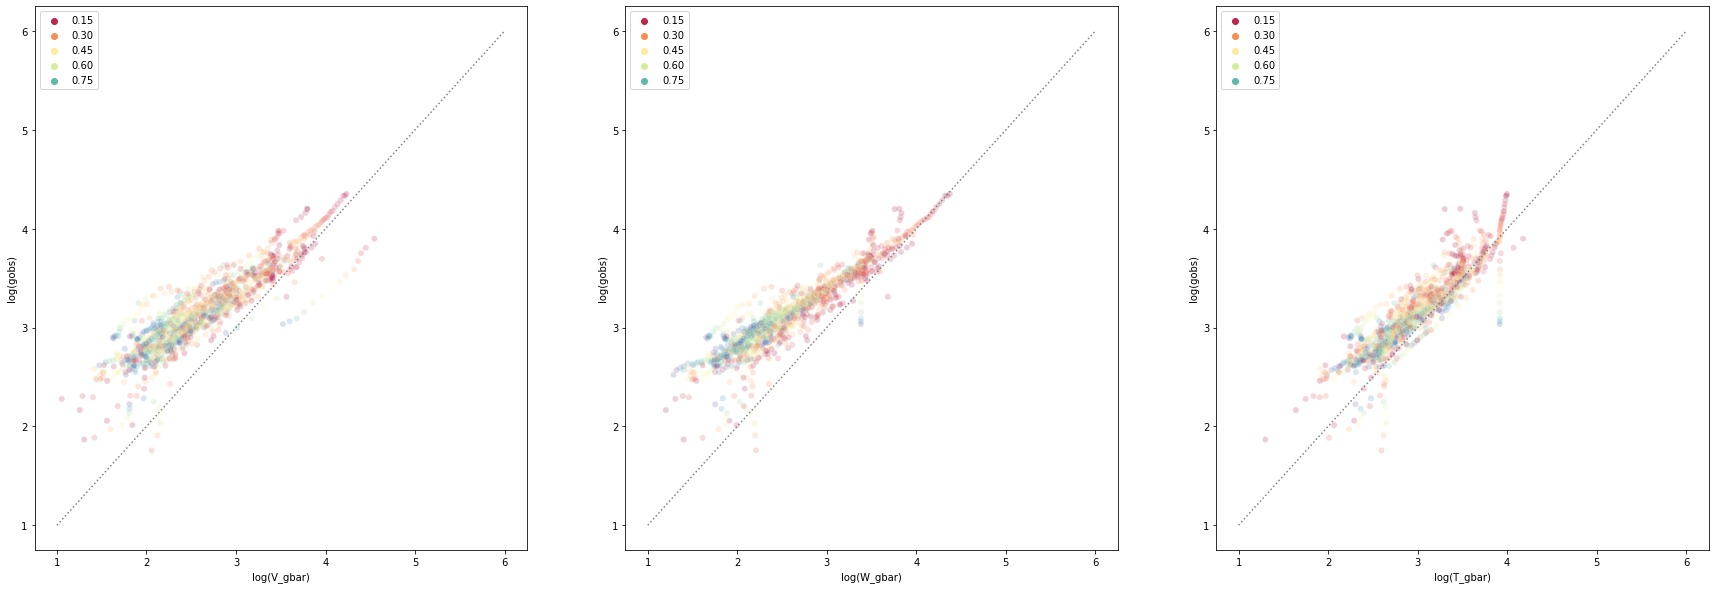

In [56]:
def plot_rar(df):
    fig, axes = plt.subplots(1, 3, figsize=(30,10))
    for i, iden in enumerate(('V', 'W', 'T')):
        g = sns.scatterplot(data=df, x='log(%s_gbar)' % iden, y='log(gobs)', alpha=0.2, hue='rel_R', palette='Spectral', ax=axes[i])
        #g.set(xscale="log", yscale="log")
        
        line = [1,6]
        sns.lineplot(x=line, y=line, color='grey', ax=axes[i], linestyle='dotted')

[plot_rar(d) for d in datasets]

0.9897349991460425 -0.0019182531885427474


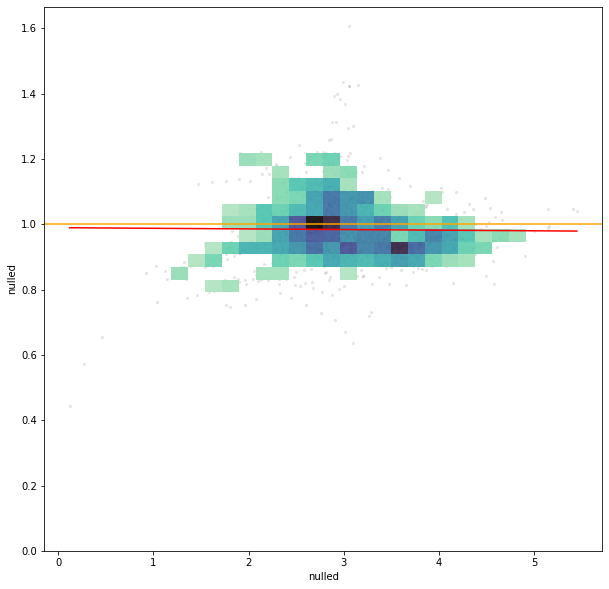

In [411]:
"""
OTHER CANDIDATES

Best so far is force*gamma*(epsilon**(nulled**alpha))
Logisitic function force/(1+e**(nulled**alpha + epsilon))

"""



def nulled_plot(df):
    fig, axes = plt.subplots(1,1, figsize=(10,10))
    x = np.log10(df['nulled'])
    y = df['log(gobs)']/(1.8*df['log(W_gbar)']/(x**(0.35)))
    sns.scatterplot(data=df, x=x, y=y, color='black', s=10, alpha=0.1)
    sns.histplot(data=df, x=x, y=y, bins=30, pthresh=.1, cmap="mako_r", alpha=0.9)
    result = sp.stats.linregress(x, y)
    sns.lineplot(x=x, y=result.slope*x+result.intercept, color='red').set(ylim=(0,None))
    axes.axhline(y=1, color='orange')
    print(result.intercept, result.slope)
    #sns.regplot(x=x, y=y, order=1, x_bins=20, color='orange')
    

nulled_plot(filtered_df)

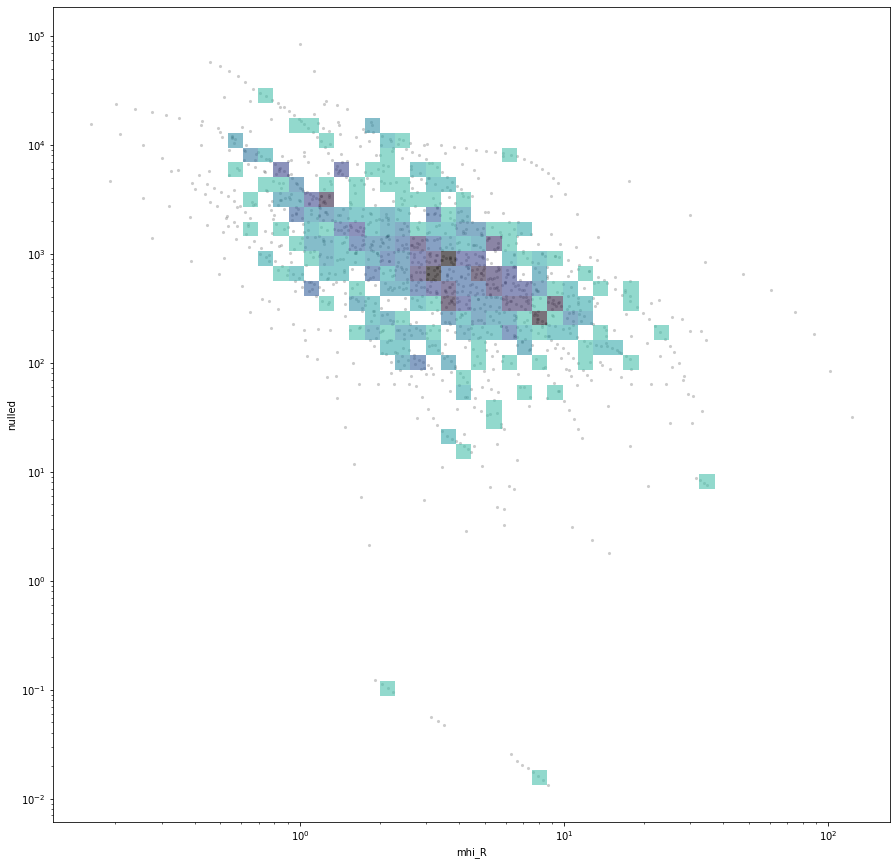

In [35]:
def relationship(df):
    x = 'mhi_R'
    y = 'nulled'
    fig, axes = plt.subplots(1, 1, figsize=(15,15))
    sns.scatterplot(data=df, x=x, y=y, color='black', s=10, alpha=0.2).set(xscale='log', yscale='log')
    sns.histplot(data=df, x=x, y=y, bins=50, pthresh=.2, cmap="mako_r", alpha=0.6)

relationship(filtered_df)

,check,r2,rslope,rstderr,rintercept
0,rel_R,0.044395,-0.207460,0.024138,1.106353
1,nulled,0.105283,0.089561,0.006548,0.752166
2,mhi_R,0.043373,-0.101027,0.011899,1.057074
3,R,0.131823,-0.182641,0.011755,1.131726
4,D,0.020011,-0.078784,0.013827,1.102178
5,MHI,0.013603,-0.046517,0.009934,1.033237


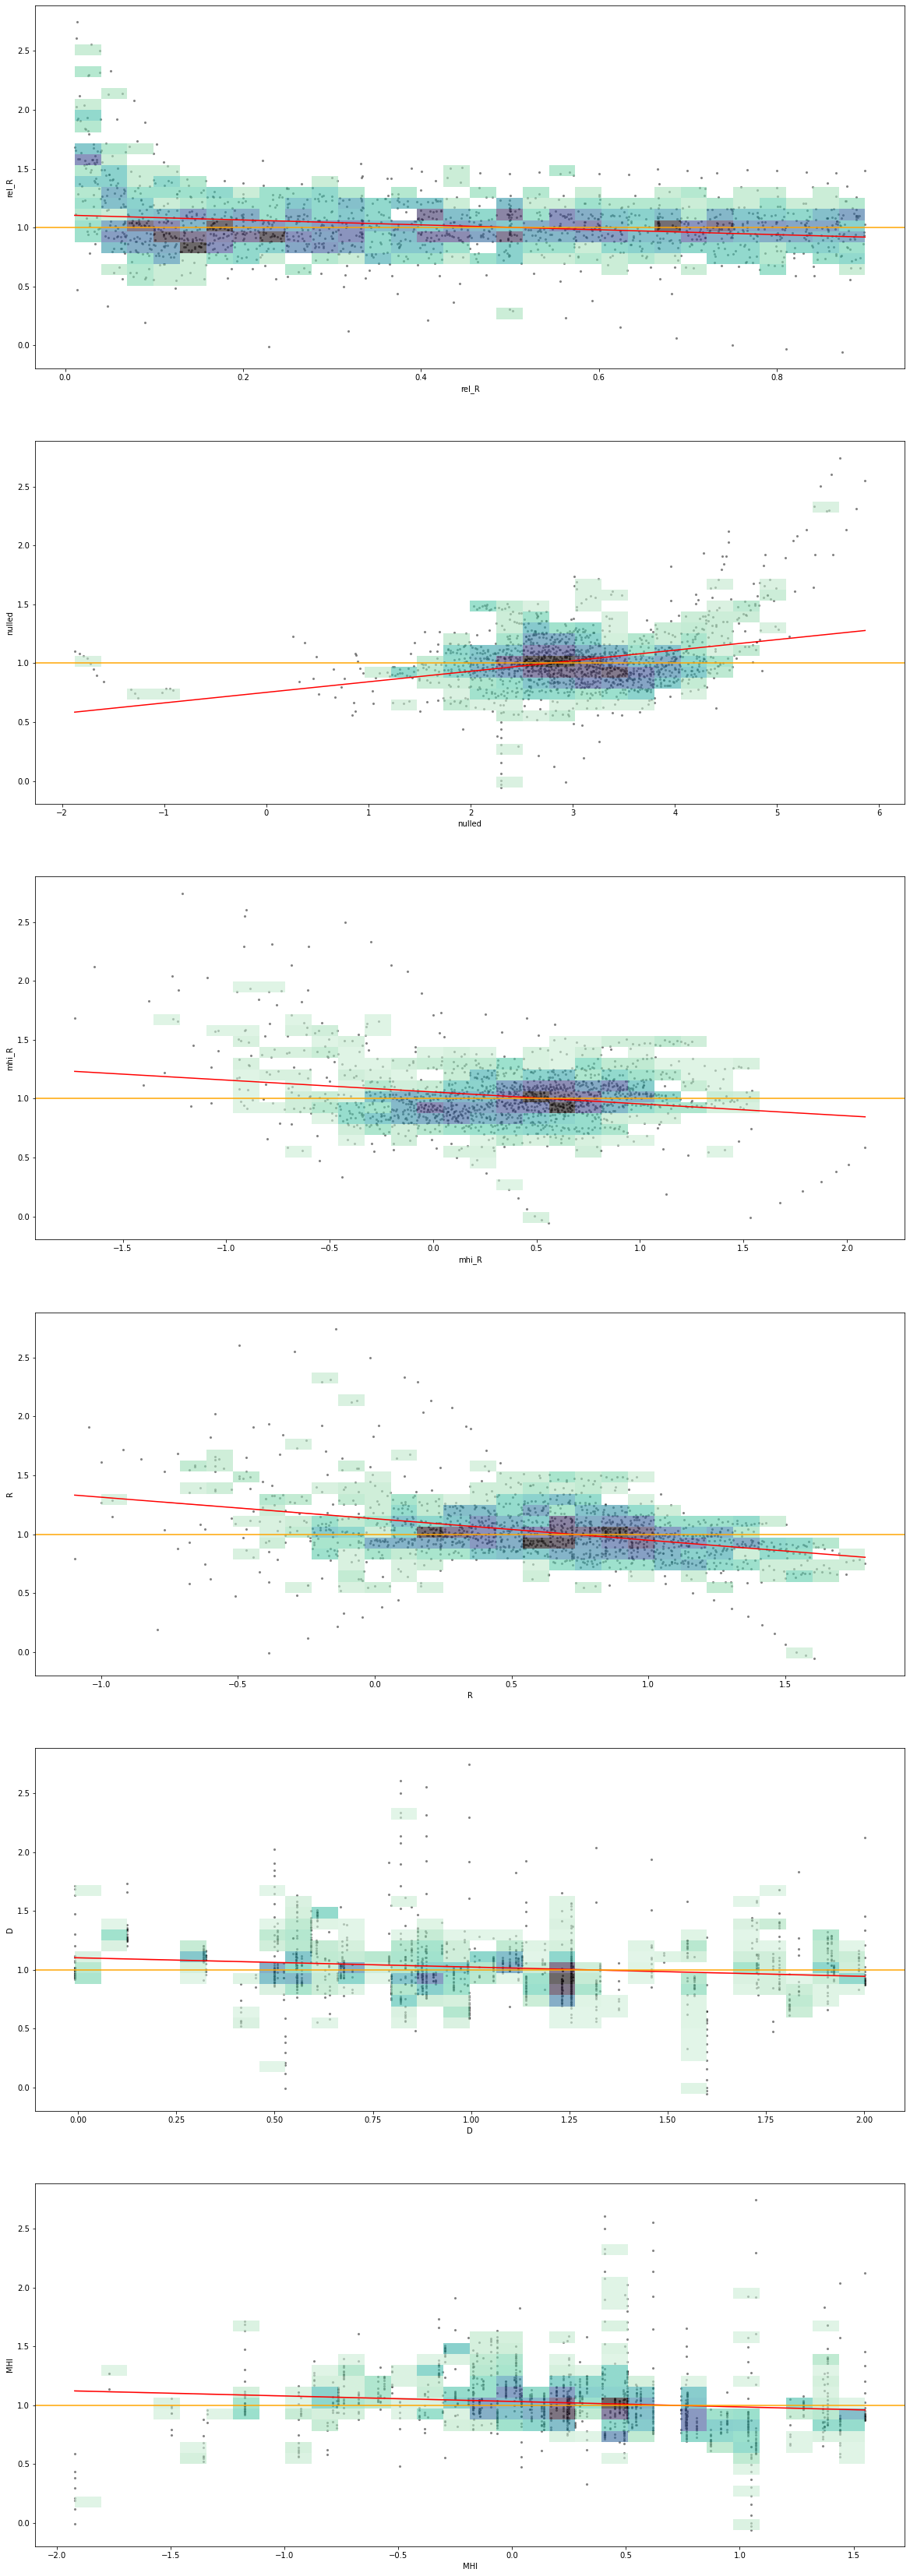

In [24]:
def residual_plots(df, iden='V', checks={'rel_R':1, 'nulled':0, 'mhi_R':0, 'R':0, 'D':0, 'MHI':0}):
    data = []
    fig, axes = plt.subplots(len(checks), 1, figsize=(20,10*len(checks)))
    for i, c in enumerate(checks.keys()):
        if checks[c]:
            x = df[c]
        else:
            x = np.log10(df[c])
        nulled = df['nulled']
        yprime = (1.8*df['W_gbar']*(0.6**(nulled**0.17)))
        #yprime = df['W_gbar']
        #yprime = 
        y = np.log10(df['gobs']/yprime)
        result = sp.stats.linregress(x, y)
        sns.scatterplot(x=x, y=y, color='black', s=10, alpha=0.5, ax=axes[i])
        sns.histplot(x=x, y=y, bins=30, pthresh=.05, cmap="mako_r", alpha=0.6, ax=axes[i])
        sns.lineplot(x=x, y=result.slope*x+result.intercept, color='red', ax=axes[i])
        axes[i].axhline(y=1, color='orange')
        data.append({
            'check': c,
            'r2': result.rvalue**2,
            'rslope': result.slope,
            'rstderr': result.stderr,
            'rintercept': result.intercept
        })
    
    return pd.DataFrame(data)

residual_plots(filtered_df)

[None]

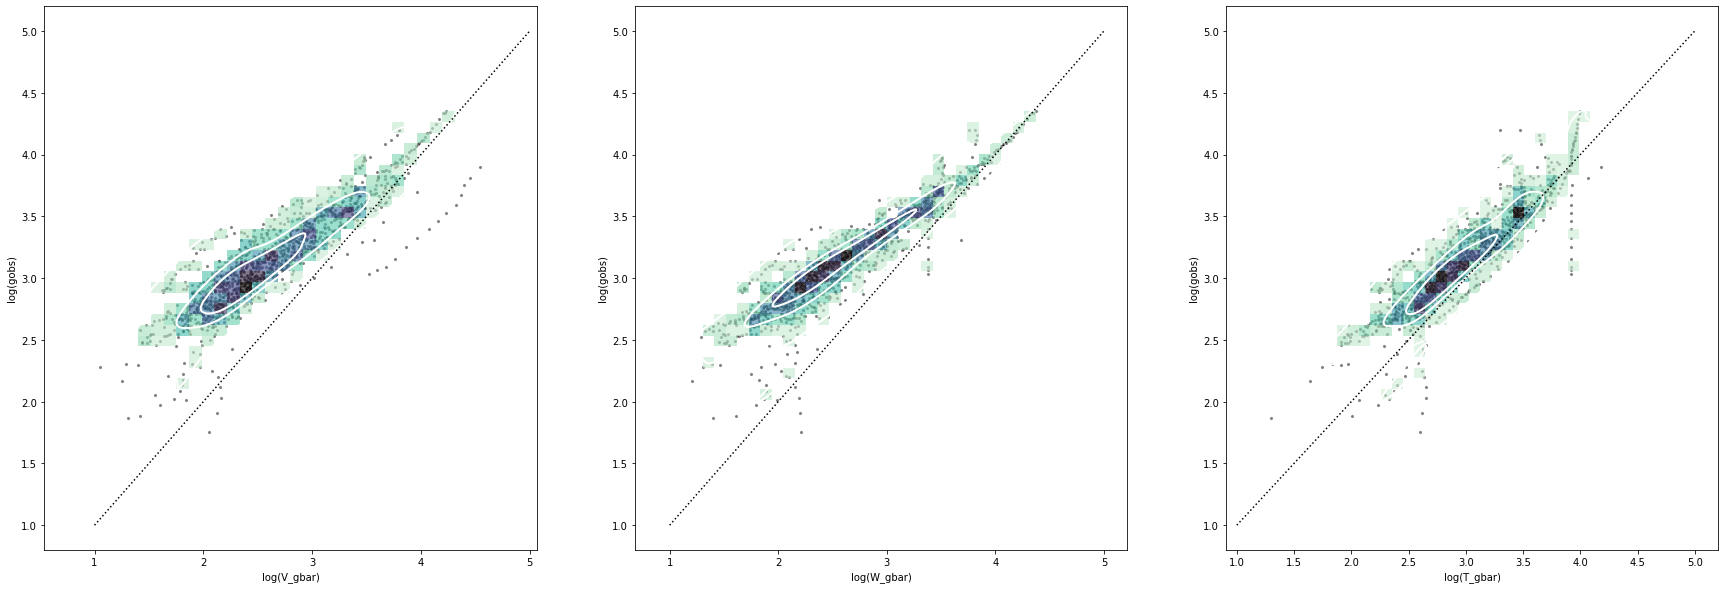

In [57]:
def plot_rar_denity(df, line=[1,5]):
    fig, axes = plt.subplots(1, 3, figsize=(30,10))
    for i, iden in enumerate(('V', 'W', 'T')):
        x = 'log(%s_gbar)' % iden
        y = 'log(gobs)'
        sns.scatterplot(data=df, x=x, y=y, color='black', s=10, alpha=0.5, ax=axes[i])
        sns.histplot(data=df, x=x, y=y, bins=30, pthresh=.01, cmap="mako_r", ax=axes[i], alpha=0.6)
        sns.kdeplot(data=df, x=x, y=y, levels=4, color="w", linewidths=2, ax=axes[i])
        sns.lineplot(x=line, y=line, color='black', linestyle='dotted', ax=axes[i])
        #sns.regplot(data=df, x=x, y=y, order=1, ax=axes[i], x_bins=10, color='orange')

[plot_rar_denity(d) for d in datasets]

[None]

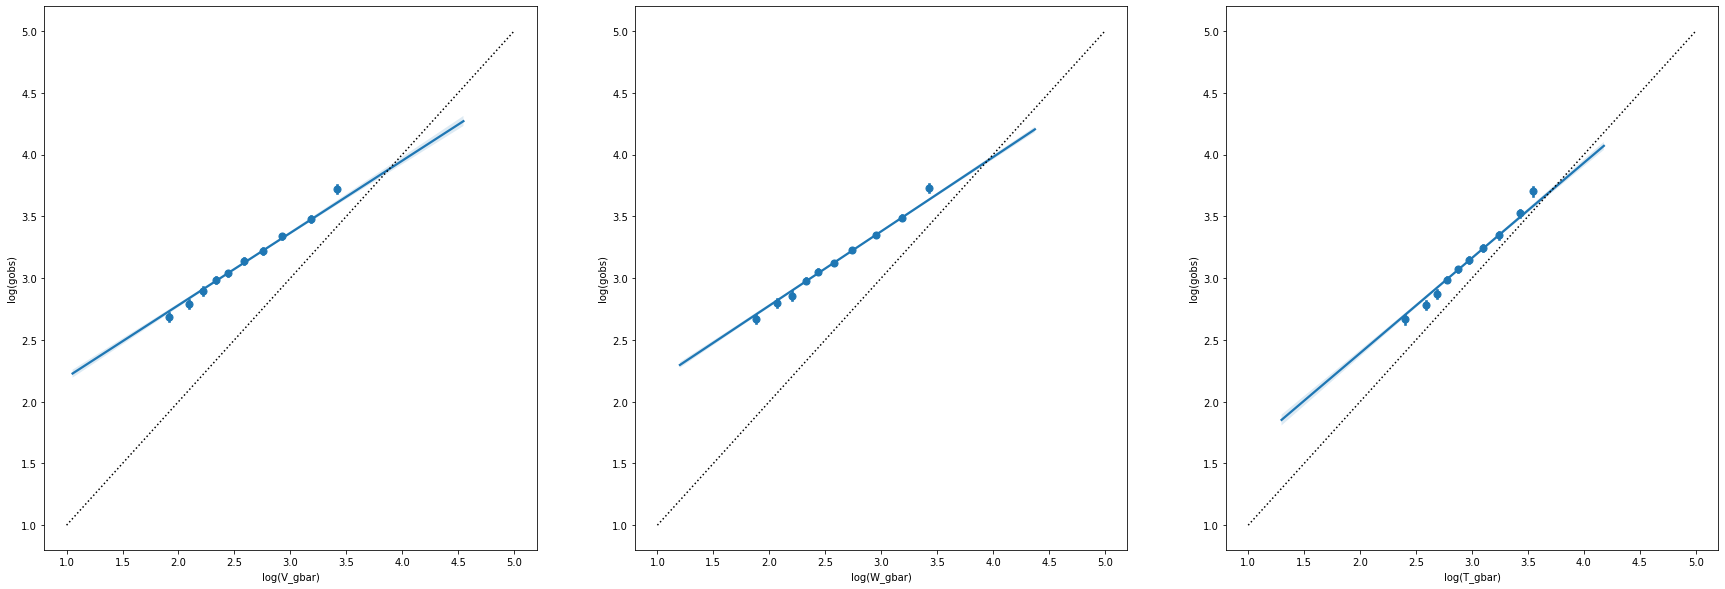

In [58]:
def plot_rar_regplot(df, line=[1,5]):
    fig, axes = plt.subplots(1, 3, figsize=(30,10))
    for i, iden in enumerate(('V', 'W', 'T')):
        x = 'log(%s_gbar)' % iden
        y = 'log(gobs)'
        sns.regplot(data=df, x=x, y=y, order=1, ax=axes[i], x_bins=10)
        sns.lineplot(x=line, y=line, color='black', linestyle='dotted', ax=axes[i])

[plot_rar_regplot(d) for d in datasets]